# PPO with Behavior Cloning Initialization (Passive Walker)

In this notebook, we demonstrate Proximal Policy Optimization (PPO) for the Passive Walker robot, initializing with a neural network policy pre-trained via Behavior Cloning (BC).

- **We reuse functions from the `passive_walker.ppo.bc_init` package.**
- **This notebook provides:**
    - Loading the BC model and initializing PPO
    - Running the PPO training loop (with critic)
    - Visualizing training progress
    - GUI rollouts for qualitative results

---


## 1. Setup & Imports

We import all necessary modules and ensure the device (CPU/GPU) is selected for JAX.

In [1]:
# Standard packages
import os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pickle

# Project-specific utilities
from passive_walker.ppo.bc_init.utils import (
    initialize_policy, 
    collect_trajectories, 
    compute_advantages, 
    save_pickle, 
    load_pickle,
)
from passive_walker.ppo.bc_init.train import Critic

# Set JAX backend
from passive_walker.ppo.bc_init import set_device
set_device(use_gpu=True)  # or False if you don't have GPU

# Set paths
from passive_walker.constants  import XML_PATH, BC_DATA, PPO_BC_DATA
BC_MODEL_PATH = BC_DATA/ "hip_knee_mse_controller.pkl"
PPO_DATA_DIR = "data/ppo/bc_init"
os.makedirs(PPO_DATA_DIR, exist_ok=True)

OUTPUT_DIR = str(PPO_BC_DATA)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set device: set_device(True) for GPU, set_device(False) for CPU
set_device(True)
print(f"Using device: {jax.default_backend()}")


Using device: cpu


## 2. Load BC Model & Initialize PPO Environment

We load the BC-seeded policy, and create all necessary action functions for training.

In [2]:
# Load the BC model and create env/policy functions
env, get_scaled_action, get_env_action, policy = initialize_policy(
    model_path=BC_MODEL_PATH,
    xml_path=str(XML_PATH),
    simend=30.0,
    sigma=0.1,
    use_gui=False,
)
obs_dim = env.observation_space.shape[0]
print(f"Loaded BC policy. Obs dim: {obs_dim}")

Loaded BC policy. Obs dim: 11


## 3. PPO Training Loop (with Critic)

We run PPO training using the loaded BC policy as the initial policy.  
We use our Critic class and standard functions from our codebase.

In [3]:
import equinox as eqx
import optax

# Hyperparameters (edit for your experiments)
num_iters = 10
rollout_steps = 2048
ppo_epochs = 10
batch_size = 256
gamma = 0.99
lam = 0.95
clip_eps = 0.2
sigma = 0.1
lr_policy = 3e-4
lr_critic = 1e-3
bc_coef = 1.0
bc_anneal_steps = 200_000

# Critic and optimizers
critic = Critic(obs_dim, hidden=64, key=jax.random.PRNGKey(0))
policy_opt = optax.adam(lr_policy)
critic_opt = optax.adam(lr_critic)
policy_state = policy_opt.init(eqx.filter(policy, eqx.is_array))
critic_state = critic_opt.init(eqx.filter(critic, eqx.is_array))

reward_history = []
bc_coef_history = []
total_steps = 0

# Use the loss and update functions from your previous code, or import if modularized!
def policy_log_prob(model, obs, acts, sigma=sigma):
    mean = jax.vmap(model)(obs)
    var = sigma ** 2
    log_std = jnp.log(sigma)
    lp = -0.5 * (((acts - mean) ** 2) / var + 2 * log_std + jnp.log(2 * jnp.pi))
    return jnp.sum(lp, axis=-1)

for it in range(1, num_iters + 1):
    # 1. Collect on-policy data
    traj = collect_trajectories(
        env=env,
        env_action_fn=get_env_action,
        scaled_action_fn=get_scaled_action,
        num_steps=rollout_steps,
        render=False
    )
    obs = jnp.array(traj["obs"], dtype=jnp.float32)
    acts = jnp.array(traj["scaled_actions"], dtype=jnp.float32)
    rewards = np.array(traj["rewards"])
    dones = np.array(traj["dones"])
    bc_labels = acts  # BC loss is on scaled actions

    # 2. Compute GAE advantages/returns
    vals = np.array(jax.vmap(critic)(obs))
    adv, ret = compute_advantages(rewards, dones, vals, gamma=gamma, lam=lam)
    adv_j = jnp.array(adv, dtype=jnp.float32)
    ret_j = jnp.array(ret, dtype=jnp.float32)
    old_lp = policy_log_prob(policy, obs, acts, sigma)

    # 3. Anneal BC coefficient
    bc_weight = bc_coef * max(0.0, 1 - total_steps / bc_anneal_steps)

    # 4. PPO and Critic updates (mini-batch)
    idxs = np.arange(obs.shape[0])
    for _ in range(ppo_epochs):
        np.random.shuffle(idxs)
        for start in range(0, len(idxs), batch_size):
            b = idxs[start:start+batch_size]
            # PPO update
            def loss_fn(policy_, obs_, acts_, old_lp_, adv_, bc_labels_):
                new_lp = policy_log_prob(policy_, obs_, acts_, sigma)
                ratio = jnp.exp(new_lp - old_lp_)
                clipped_obj = jnp.clip(ratio, 1-clip_eps, 1+clip_eps) * adv_
                ppo_obj = -jnp.mean(jnp.minimum(ratio * adv_, clipped_obj))
                im_loss = jnp.mean((jax.vmap(policy_)(obs_) - bc_labels_)**2)
                return ppo_obj + bc_weight * im_loss

            grads = jax.grad(loss_fn)(
                policy, obs[b], acts[b], old_lp[b], adv_j[b], acts[b])
            updates, policy_state = policy_opt.update(grads, policy_state)
            policy = eqx.apply_updates(policy, updates)
            # Critic update
            def vf_loss(critic_, obs_, ret_):
                return jnp.mean((jax.vmap(critic_)(obs_) - ret_)**2)
            vf_grads = jax.grad(vf_loss)(critic, obs[b], ret_j[b])
            vf_updates, critic_state = critic_opt.update(vf_grads, critic_state)
            critic = eqx.apply_updates(critic, vf_updates)

    avg_reward = rewards.mean()
    reward_history.append(avg_reward)
    bc_coef_history.append(bc_weight)
    total_steps += rollout_steps
    print(f"[PPO] iter {it}/{num_iters}  avg_rew={avg_reward:.2f}  bc_coef={bc_weight:.3f}")

# Save policy/critic if desired
with open(os.path.join(OUTPUT_DIR, "trained_policy_with_critic.pkl"), "wb") as f:
    pickle.dump((policy, critic), f)

[PPO] iter 1/10  avg_rew=0.38  bc_coef=1.000
[PPO] iter 2/10  avg_rew=0.43  bc_coef=0.990
[PPO] iter 3/10  avg_rew=0.44  bc_coef=0.980
[PPO] iter 4/10  avg_rew=0.42  bc_coef=0.969
[PPO] iter 5/10  avg_rew=0.46  bc_coef=0.959
[PPO] iter 6/10  avg_rew=0.43  bc_coef=0.949
[PPO] iter 7/10  avg_rew=0.42  bc_coef=0.939
[PPO] iter 8/10  avg_rew=0.41  bc_coef=0.928
[PPO] iter 9/10  avg_rew=0.42  bc_coef=0.918
[PPO] iter 10/10  avg_rew=0.43  bc_coef=0.908


## 5. PPO Training Diagnostics and Analysis

Below, we plot the average reward per PPO iteration and the BC coefficient annealing curve.

In [4]:
# Save reward and BC coefficient histories for later analysis/plots
log = {
    "rewards": reward_history,
    "bc_coef": bc_coef_history,
}
log_path = os.path.join(OUTPUT_DIR, "ppo_training_log.pkl")
save_pickle(log, log_path)
print(f"[log] Training history saved to {log_path}")

[log] Training history saved to /home/yunusdanabas/ENS492/passive_walker_rl/data/ppo/bc/ppo_training_log.pkl


[plot] Saved training curve → /home/yunusdanabas/ENS492/passive_walker_rl/data/ppo/bc/ppo_training_curve.png


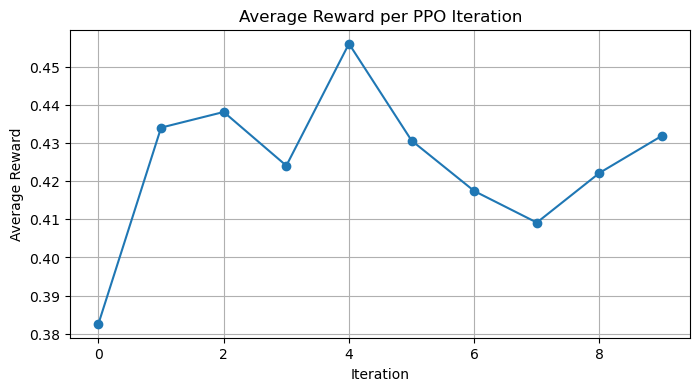

Number of training iterations: 10
Final average reward: 0.43
Improvement: 0.05 (12.9%)


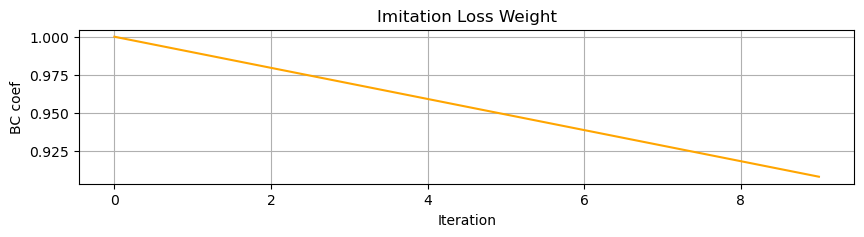

In [5]:
from passive_walker.ppo.bc_init.utils import analyze_training_log, plot_bc_coefficient

# Plot reward learning curve
analyze_training_log(
    log_path=os.path.join(OUTPUT_DIR, "ppo_training_log.pkl"),
    save_path=os.path.join(OUTPUT_DIR, "ppo_training_curve.png"),
    title="Average Reward per PPO Iteration"
)

# Plot BC coefficient annealing
log = load_pickle(os.path.join(OUTPUT_DIR, "ppo_training_log.pkl"))
plot_bc_coefficient(log["bc_coef"], output_dir=OUTPUT_DIR)

In [6]:
from passive_walker.ppo.bc_init.utils import plot_joint_and_reward

# Create environment for evaluation (GUI if you want to see it, otherwise use_gui=False)
env, get_scaled_action, get_env_action, _ = initialize_policy(
    model_path=os.path.join(OUTPUT_DIR, "trained_policy_with_critic.pkl"),
    xml_path=str(XML_PATH),
    simend=30.0,
    sigma=0.1,
    use_gui=False,
)

obs = env.reset()
traj_obs = []
rewards = []
done = False
while not done:
    obs_jnp = jnp.array(obs, dtype=jnp.float32)
    act = get_env_action(obs_jnp)
    obs, r, done, _ = env.step(act)
    traj_obs.append(obs)
    rewards.append(r)
    # env.render()  # Optionally show GUI

traj_obs = np.array(traj_obs)
rewards = np.array(rewards)

# Save for later
np.save(os.path.join(OUTPUT_DIR, "ppo_eval_joint_positions.npy"), traj_obs)
np.save(os.path.join(OUTPUT_DIR, "ppo_eval_rewards.npy"), rewards)

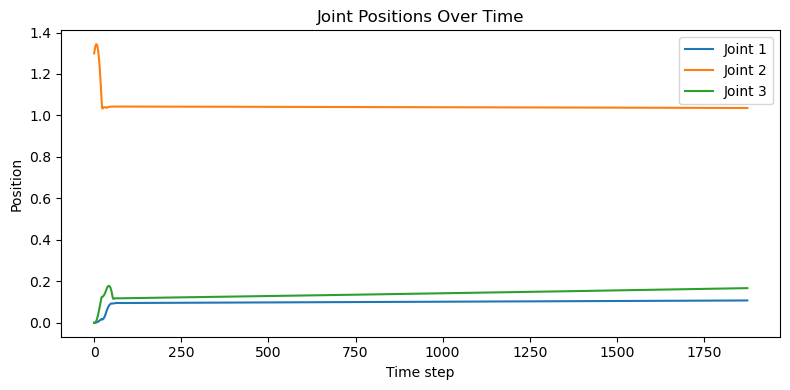

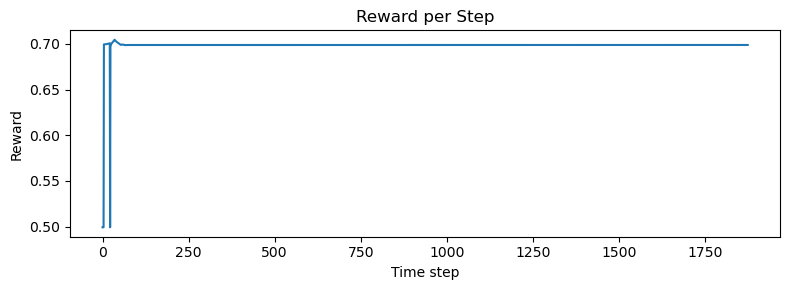

In [7]:
# Plot and save
plot_joint_and_reward(traj_obs, rewards, save_prefix=os.path.join(OUTPUT_DIR, "ppo_eval"))

# Export as CSV for your report
np.savetxt(os.path.join(OUTPUT_DIR, "ppo_eval_joint_positions.csv"), traj_obs, delimiter=",")
np.savetxt(os.path.join(OUTPUT_DIR, "ppo_eval_rewards.csv"), rewards, delimiter=",")

## 6. GUI Rollout Demo

Play the trained PPO policy in Mujoco for a visual check!

In [8]:
env_gui, get_scaled_action, get_env_action, policy = initialize_policy(
    model_path=os.path.join(OUTPUT_DIR, "trained_policy_with_critic.pkl"),
    xml_path=str(XML_PATH),
    simend=30.0,
    sigma=sigma,
    use_gui=True,
)

obs = env_gui.reset()
done = False
while not done:
    act = get_env_action(jnp.array(obs))
    obs, reward, done, info = env_gui.step(act)
    env_gui.render()
    if done:
        break
env_gui.close()